In [96]:
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
# NEW
import random
import time
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm

In [97]:
outpath = "/oak/stanford/groups/horence/JuliaO/visium_analysis/notebooks/output/Ising/"

In [106]:
dataname = "V1_Mouse_Brain_Sagittal_Posterior"
# dataname = "V1_Mouse_Brain_Sagittal_Posterior_Section_2"

# dataname = "V1_Mouse_Brain_Sagittal_Anterior"
# dataname = "V1_Mouse_Brain_Sagittal_Anterior_Section_2"
# dataname = "V1_Mouse_Kidney"
samples = pd.read_csv("output/make_samplesheet/spatial.csv",index_col = 0)
# samples
row = samples.loc[dataname]

# score = "ReadZS"
# score = "ReadZS_norm"
thresh = 1000

# score = "SpliZ_norm"
score = "ReadZS_norm"
# score = "SpliZ_resid"
# # score2 = "ge"
# thresh = 100


scores = pd.read_csv("output/make_samplesheet/scores.csv",index_col=0)
srow = scores.loc[score]
# srow2 = scores.loc[score2]
df = pd.read_csv(row[srow["valname"]],sep="\t")

In [107]:
radius = int(row["radius"])
xcol = "plot_xcoord"
ycol = "plot_ycoord"
# gene = "Rps24"
# gene = "Ptprc"



df["x_y"] = df[xcol].astype(str) + "_" + df[ycol].astype(str)
temp = df.drop_duplicates("x_y")[[xcol,ycol,"x_y"]]

# mark neighbors
out = {"x_y1": [], "x_y2" : []}
for index, row in temp.iterrows():
  temp2 = temp[(temp[xcol] > row[xcol] - radius) & (temp[xcol] < row[xcol] + radius)& (temp[ycol] < row[ycol] + radius) & (temp[ycol] > row[ycol] - radius) & (temp["x_y"] != row["x_y"])]
  for ind2, row2 in temp2.iterrows():
    
    out["x_y1"].append(min([row["x_y"],row2["x_y"]]))
    out["x_y2"].append(max([row["x_y"],row2["x_y"]]))
outdf = pd.DataFrame.from_dict(out)
outdf = outdf.drop_duplicates()


In [108]:

# NEW
prod_df = pd.DataFrame(columns = outdf["x_y1"] + ":" + outdf["x_y2"],index=df[srow["genecol"]].unique())

# create null distribution for each pair of neighbors
perm_dist = defaultdict(lambda : [])

prods = []
# loop over all genes
for gene, genedf in tqdm(df.groupby(srow["genecol"])):
  
  # get indicies of neighbors present for this gene
  ind1 = outdf[(outdf["x_y1"].isin(genedf["x_y"])) & (outdf["x_y2"].isin(genedf["x_y"]))]["x_y1"]
  ind2 = outdf[(outdf["x_y1"].isin(genedf["x_y"])) & (outdf["x_y2"].isin(genedf["x_y"]))]["x_y2"]

  # get score values for the first neighbor
  pair1 = genedf.set_index("x_y").loc[list(ind1)][srow["col"]]
  
  # get score values for the second neighbor
  pair2 = genedf.set_index("x_y").loc[list(ind2)][srow["col"]]

  # get the product of these two vectors (what will be summed to create the Ising score)
  newind = ["{}:{}".format(x,y) for x, y in zip(pair1.index,pair2.index)]
  pair1.index = newind
  pair2.index = newind
  prod = pair1.multiply(pair2)
  
  # NEW
  prod_df.loc[gene,newind] = prod
  prods.append(prod)
  
  # save the product for each of these neighbors
  for index, value in prod.items():
    perm_dist[index].append(value)

perm_dist_ser = pd.concat(prods)

# # NEW
# # fill na values with random choice from non-na
# prod_df = prod_df.apply(lambda x: x.fillna(random.choice(x.dropna())), axis=1)

100%|██████████| 5314/5314 [01:43<00:00, 51.26it/s]


In [103]:
num_perms = 100

vc = df[srow["genecol"]].value_counts()
t0 = time.time()
out = {srow["genecol"] : [],  "score_cont" : [], "num_pairs" : [],  "perm_pval2" : [], "perm_pval3" : []}
for gene in tqdm(vc[vc > thresh].index):

  genedf = df[df[srow["genecol"]] == gene]

  if (abs(genedf[srow["col"]].mean()) < 0.1):
#   if (abs(genedf[srow["col"]].mean()) < 0.1) and (gene in ["Ptgds","Myl6","Rps24","Gas5"]):

    
    # get indicies of neighbors present for this gene
    ind1 = outdf[(outdf["x_y1"].isin(genedf["x_y"])) & (outdf["x_y2"].isin(genedf["x_y"]))]["x_y1"]
    ind2 = outdf[(outdf["x_y1"].isin(genedf["x_y"])) & (outdf["x_y2"].isin(genedf["x_y"]))]["x_y2"]
    num_pairs = ind1.shape[0]
    
    # index by these indices and then take the dot product
    pair1 = genedf.set_index("x_y").loc[list(ind1)][srow["col"]]
    pair2 = genedf.set_index("x_y").loc[list(ind2)][srow["col"]]
    newind = ["{}:{}".format(x,y) for x, y in zip(pair1.index,pair2.index)]
    dot_prod = np.dot(pair1,pair2)

#     print("before 1",time.time() - t0)
#     perm_dot_prods1 = []
#     for i in range(num_perms):
# #       print(i,time.time() - t0)
#       perm_dot_prods1.append(sum([np.random.choice(perm_dist[x]) for x in newind]))
#     print("before 3",time.time() - t0)
    
#     perm_dot_prods3 = []
#     for i in range(num_perms):
#       print(i,time.time() - t0)
#       temp = perm_dist_ser.loc[newind].sample(frac=1)
#       temp[~temp.index.duplicated(keep="first")].sum()
#       perm_dot_prods3.append(temp[~temp.index.duplicated(keep="first")].sum())
    print("before 2",time.time() - t0)
    perm_dot_prods2 = []
    for i in range(num_perms):
      genedf["perm"] = np.random.permutation(genedf[srow["col"]])
      perm_dot_prods2.append(np.dot(genedf.set_index("x_y").loc[list(ind1)]["perm"],genedf.set_index("x_y").loc[list(ind2)]["perm"]))
    
    print("before 3", time.time() - t0)
    # new
    # NEW
    # subset to only edges present for this gene
    # for each column, randomly choose a value num_perms times (skipping NAs)
    # sum the values across each permutation
    perm_dot_prods3 = list(prod_df[newind].apply(lambda x: np.random.choice(x.dropna(),num_perms), axis=0).sum(axis=1))
    print("after 3",time.time() - t0)
#     out["perm_pval1"].append(len([x for x in perm_dot_prods1 if x > dot_prod])/num_perms)
    out["perm_pval2"].append(len([x for x in perm_dot_prods2 if x > dot_prod])/num_perms)
    out["perm_pval3"].append(len([x for x in perm_dot_prods3 if x > dot_prod])/num_perms)
#     out["perm_pval2"].append(len([x for x in perm_dot_prods3 if x > dot_prod])/num_perms)
    out[srow["genecol"]].append(gene)
    out["score_cont"].append(dot_prod/num_pairs)
    out["num_pairs"].append(num_pairs)


  0%|          | 0/1326 [00:00<?, ?it/s]/home/users/jolivier/.local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


before 2 0.1234750747680664
before 3 0.8158168792724609


  0%|          | 1/1326 [00:02<47:25,  2.15s/it]

after 3 2.149014472961426
before 2 2.2688791751861572
before 3 2.964165449142456


  0%|          | 2/1326 [00:04<46:45,  2.12s/it]

after 3 4.247795343399048
before 2 4.36978554725647
before 3 5.065062761306763


  0%|          | 3/1326 [00:06<46:54,  2.13s/it]

after 3 6.385951519012451
before 2 6.5075907707214355
before 3 7.205639600753784


  0%|          | 4/1326 [00:08<46:43,  2.12s/it]

after 3 8.49525785446167
before 2 8.617356300354004
before 3 9.326331853866577


  0%|          | 5/1326 [00:10<46:43,  2.12s/it]

after 3 10.620806694030762
before 2 10.73691725730896
before 3 11.415412902832031


  0%|          | 6/1326 [00:12<46:29,  2.11s/it]

after 3 12.715888023376465
before 2 12.837103843688965
before 3 13.530115365982056


  1%|          | 7/1326 [00:14<46:26,  2.11s/it]

after 3 14.82656717300415
before 2 14.944198608398438
before 3 15.632960319519043


  1%|          | 8/1326 [00:16<46:19,  2.11s/it]

after 3 16.92743182182312
before 2 17.04593563079834
before 3 17.738912105560303


  1%|          | 9/1326 [00:19<46:19,  2.11s/it]

after 3 19.042760372161865
before 2 19.16350817680359
before 3 19.86049771308899


  1%|          | 10/1326 [00:21<46:18,  2.11s/it]

after 3 21.154447317123413
before 2 21.27818489074707
before 3 21.959933042526245


  1%|          | 11/1326 [00:23<46:13,  2.11s/it]

after 3 23.25951313972473
before 2 23.379260063171387
before 3 24.067267179489136


  1%|          | 12/1326 [00:25<46:06,  2.11s/it]

after 3 25.355184316635132
before 2 25.47597908973694
before 3 26.16580820083618


  1%|          | 13/1326 [00:27<46:10,  2.11s/it]

after 3 27.475911617279053
before 2 27.595527172088623
before 3 28.26631212234497


  1%|          | 14/1326 [00:29<46:05,  2.11s/it]

after 3 29.5792133808136
before 2 29.699952125549316
before 3 30.378448009490967


  1%|          | 15/1326 [00:31<46:13,  2.12s/it]

after 3 31.711585760116577
before 2 31.842731714248657
before 3 32.53621244430542


  1%|          | 16/1326 [00:33<46:23,  2.13s/it]

after 3 33.859532594680786
before 2 33.99039912223816
before 3 34.67942261695862


  1%|▏         | 17/1326 [00:35<46:18,  2.12s/it]

after 3 35.977468967437744
before 2 36.0995774269104
before 3 36.78061842918396


  1%|▏         | 18/1326 [00:38<46:01,  2.11s/it]

after 3 38.06031560897827
before 2 38.190021276474
before 3 38.865545988082886


  1%|▏         | 19/1326 [00:40<45:54,  2.11s/it]

after 3 40.15927815437317
before 2 40.28857755661011
before 3 40.971513509750366


  2%|▏         | 20/1326 [00:42<45:51,  2.11s/it]

after 3 42.26544642448425
before 2 42.39391803741455
before 3 43.08351516723633


  2%|▏         | 21/1326 [00:44<46:06,  2.12s/it]

after 3 44.416181564331055
before 2 44.545429706573486
before 3 45.22552013397217


  2%|▏         | 22/1326 [00:46<45:54,  2.11s/it]

after 3 46.50996446609497
before 2 46.64108085632324
before 3 47.32859253883362


  2%|▏         | 23/1326 [00:48<45:58,  2.12s/it]

after 3 48.63915395736694
before 2 48.76003050804138
before 3 49.44363260269165


  2%|▏         | 24/1326 [00:50<45:41,  2.11s/it]

after 3 50.718026876449585
before 2 50.851073026657104
before 3 51.54020380973816


  2%|▏         | 25/1326 [00:52<45:40,  2.11s/it]

after 3 52.827006578445435
before 2 52.952942848205566
before 3 53.6252760887146


  2%|▏         | 26/1326 [00:54<45:31,  2.10s/it]

after 3 54.915910720825195
before 2 55.03738331794739
before 3 55.712990522384644


  2%|▏         | 27/1326 [00:57<45:26,  2.10s/it]

after 3 57.00965189933777
before 2 57.13089609146118
before 3 57.81333518028259


  2%|▏         | 28/1326 [00:59<45:23,  2.10s/it]

after 3 59.105653047561646
before 2 59.2264928817749
before 3 59.90210175514221


  2%|▏         | 29/1326 [01:01<45:31,  2.11s/it]

after 3 61.23117184638977
before 2 61.3539981842041
before 3 62.03416633605957


  2%|▏         | 30/1326 [01:03<45:22,  2.10s/it]

after 3 63.31797003746033
before 2 63.43854355812073
before 3 64.12049436569214


  2%|▏         | 31/1326 [01:05<45:40,  2.12s/it]

after 3 65.4708263874054
before 2 65.59270095825195
before 3 66.28218531608582


  2%|▏         | 32/1326 [01:07<45:37,  2.12s/it]

after 3 67.58474063873291
before 2 67.70537543296814
before 3 68.38248491287231


  2%|▏         | 33/1326 [01:09<45:19,  2.10s/it]

after 3 69.65958309173584
before 2 69.7845356464386
before 3 70.46865248680115


  3%|▎         | 34/1326 [01:11<45:12,  2.10s/it]

after 3 71.75118732452393
before 2 71.8685531616211
before 3 72.54465126991272


  3%|▎         | 35/1326 [01:13<45:07,  2.10s/it]

after 3 73.84147930145264
before 2 73.97308325767517
before 3 74.652170419693


  3%|▎         | 36/1326 [01:15<45:02,  2.09s/it]

after 3 75.9317569732666
before 2 76.0489137172699
before 3 76.74139356613159


  3%|▎         | 36/1326 [01:17<46:05,  2.14s/it]


KeyboardInterrupt: 

In [105]:
pd.DataFrame.from_dict(out)

,window,score_cont,num_pairs,perm_pval2,perm_pval3
0,chr7_20766_minus,0.406238,4102,0.00,0.00
1,chr11_10983_plus,0.358880,4096,0.00,0.00
2,chr7_23893_minus,0.029471,4096,0.05,0.42
3,chr11_6460_plus,0.285951,4090,0.00,0.00
4,chr11_6457_plus,0.100251,4090,0.00,0.00
5,chr10_25710_minus,0.017577,4090,0.14,0.67
6,chr6_26770_minus,0.245594,4090,0.00,0.00
7,chr7_8918_plus,0.031248,4095,0.01,0.30
8,chr7_9092_minus,0.035468,4096,0.03,0.36
9,chr8_24135_plus,0.141840,4090,0.00,0.00


NameError: name 'dotprod' is not defined

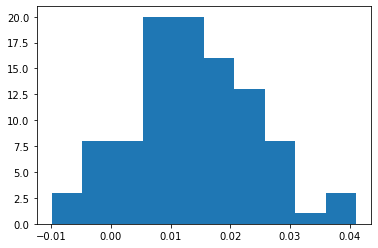

In [63]:
perm_vals = []
for i in range(100):
  perm_vals.append(sum([np.random.choice(perm_dist[x]) for x in newind])/len(newind))
plt.hist(perm_vals)
plt.axvline(x=dot_prod/num_pairs)
plt.show()

In [137]:
temp = perm_dist_ser.loc[newind].sample(frac=1)
#       print("c",time.time() - t0)
perm_dot_prods3.append(temp[~temp.index.duplicated(keep="first")].sum())

In [138]:
perm_dist_ser.loc[newind].sample(frac=1).drop_duplicates()

4386.0_-8745.0:4524.0_-8745.0    1.018353
6255.0_-5758.0:6392.0_-5758.0    0.186419
5572.0_-4319.0:5709.0_-4319.0    1.513924
5296.0_-4557.0:5365.0_-4438.0    0.023911
4462.0_-6709.0:4531.0_-6590.0   -0.598175
                                   ...   
6671.0_-4801.0:6809.0_-4802.0   -0.004297
6675.0_-3604.0:6813.0_-3605.0   -0.607364
6668.0_-5520.0:6737.0_-5640.0    0.058713
4806.0_-6830.0:4943.0_-6831.0    1.179157
5573.0_-3840.0:5643.0_-3720.0   -1.959251
Name: scZ_norm, Length: 1013992, dtype: float64

83.0397343648551

In [143]:
dot_prod

1540.5510957699296

In [46]:
for key, value in perm_dist.items():
  print(key, len(value))

20058.0_-16241.0:20348.0_-16241.0 152
19912.0_-16493.0:20058.0_-16241.0 151
19767.0_-16240.0:20058.0_-16241.0 132
20058.0_-16241.0:20203.0_-15988.0 95
20058.0_-16241.0:20202.0_-16493.0 147
19913.0_-15988.0:20058.0_-16241.0 143
11519.0_-4356.0:11809.0_-4356.0 101
11375.0_-4103.0:11519.0_-4356.0 95
11374.0_-4608.0:11519.0_-4356.0 110
11519.0_-4356.0:11665.0_-4104.0 107
11519.0_-4356.0:11664.0_-4609.0 118
11229.0_-4355.0:11519.0_-4356.0 114
18915.0_-7148.0:19059.0_-7401.0 113
18625.0_-7148.0:18915.0_-7148.0 117
18770.0_-6895.0:18915.0_-7148.0 118
18915.0_-7148.0:19060.0_-6896.0 110
18769.0_-7400.0:18915.0_-7148.0 110
18915.0_-7148.0:19205.0_-7149.0 108
19327.0_-19017.0:19471.0_-19270.0 123
19182.0_-18764.0:19327.0_-19017.0 113
19181.0_-19269.0:19327.0_-19017.0 108
19327.0_-19017.0:19472.0_-18765.0 123
19036.0_-19016.0:19327.0_-19017.0 120
19327.0_-19017.0:19617.0_-19017.0 97
21947.0_-14982.0:22237.0_-14982.0 150
21801.0_-15234.0:21947.0_-14982.0 153
21947.0_-14982.0:22091.0_-15235.0 140
2

17013.0_-14972.0:17158.0_-14720.0 134
16722.0_-14971.0:17013.0_-14972.0 152
16868.0_-14719.0:17013.0_-14972.0 140
16015.0_-5627.0:16160.0_-5880.0 91
15870.0_-5880.0:16160.0_-5880.0 104
16014.0_-6132.0:16160.0_-5880.0 105
16160.0_-5880.0:16305.0_-6133.0 104
16160.0_-5880.0:16306.0_-5628.0 104
16160.0_-5880.0:16450.0_-5881.0 103
15727.0_-4617.0:16017.0_-4617.0 127
16017.0_-4617.0:16162.0_-4870.0 107
16017.0_-4617.0:16308.0_-4618.0 125
15873.0_-4365.0:16017.0_-4617.0 117
15872.0_-4870.0:16017.0_-4617.0 123
16017.0_-4617.0:16163.0_-4365.0 135
20353.0_-13716.0:20643.0_-13717.0 152
20208.0_-13463.0:20353.0_-13716.0 159
20353.0_-13716.0:20499.0_-13464.0 152
20063.0_-13716.0:20353.0_-13716.0 152
20353.0_-13716.0:20498.0_-13969.0 159
20207.0_-13968.0:20353.0_-13716.0 159
13962.0_-16734.0:14107.0_-16481.0 134
14107.0_-16481.0:14253.0_-16229.0 134
14107.0_-16481.0:14252.0_-16734.0 120
13963.0_-16229.0:14107.0_-16481.0 166
13817.0_-16481.0:14107.0_-16481.0 120
14856.0_-4615.0:15002.0_-4363.0 116
1

9181.0_-12431.0:9472.0_-12432.0 117
9326.0_-12684.0:9472.0_-12432.0 124
9472.0_-12432.0:9617.0_-12180.0 114
9327.0_-12179.0:9472.0_-12432.0 114
13840.0_-4865.0:13986.0_-4613.0 102
13986.0_-4613.0:14276.0_-4614.0 102
13696.0_-4613.0:13986.0_-4613.0 125
13986.0_-4613.0:14131.0_-4361.0 102
13258.0_-5874.0:13403.0_-5622.0 137
13258.0_-5874.0:13548.0_-5875.0 134
13258.0_-5874.0:13402.0_-6127.0 127
13112.0_-6127.0:13258.0_-5874.0 124
13262.0_-3854.0:13552.0_-3855.0 95
13262.0_-3854.0:13407.0_-3602.0 110
13117.0_-3602.0:13262.0_-3854.0 93
12971.0_-3854.0:13262.0_-3854.0 98
13262.0_-3854.0:13406.0_-4107.0 89
14539.0_-18250.0:14684.0_-18503.0 127
14249.0_-18249.0:14539.0_-18250.0 151
14395.0_-17997.0:14539.0_-18250.0 140
14394.0_-18502.0:14539.0_-18250.0 151
22966.0_-13216.0:23112.0_-12964.0 138
23112.0_-12964.0:23257.0_-12712.0 141
22821.0_-12964.0:23112.0_-12964.0 127
23112.0_-12964.0:23402.0_-12965.0 127
22967.0_-12711.0:23112.0_-12964.0 129
16435.0_-13456.0:16580.0_-13709.0 143
16434.0_-139

15433.0_-6636.0:15579.0_-6384.0 136
15579.0_-6384.0:15869.0_-6385.0 134
10187.0_-17736.0:10477.0_-17737.0 73
10477.0_-17737.0:10621.0_-17989.0 99
10477.0_-17737.0:10767.0_-17737.0 98
10477.0_-17737.0:10622.0_-17484.0 81
17753.0_-7651.0:17898.0_-7399.0 146
17898.0_-7399.0:18043.0_-7651.0 131
12067.0_-21022.0:12357.0_-21023.0 74
11921.0_-21275.0:12067.0_-21022.0 57
12067.0_-21022.0:12212.0_-20770.0 67
11922.0_-20770.0:12067.0_-21022.0 68
19908.0_-18513.0:20054.0_-18261.0 127
19908.0_-18513.0:20053.0_-18766.0 123
19908.0_-18513.0:20198.0_-18513.0 130
12649.0_-20014.0:12794.0_-20266.0 99
12649.0_-20014.0:12939.0_-20014.0 83
12503.0_-20266.0:12649.0_-20014.0 105
12359.0_-20013.0:12649.0_-20014.0 102
11511.0_-8396.0:11801.0_-8397.0 140
11221.0_-8395.0:11511.0_-8396.0 152
11367.0_-8143.0:11511.0_-8396.0 146
11366.0_-8648.0:11511.0_-8396.0 144
11511.0_-8396.0:11656.0_-8649.0 160
9769.0_-8898.0:9914.0_-8645.0 133
9624.0_-8645.0:9769.0_-8898.0 125
10059.0_-8898.0:9769.0_-8898.0 135
9769.0_-8898.

23254.0_-14227.0:23400.0_-13975.0 150
23400.0_-13975.0:23690.0_-13975.0 161
23400.0_-13975.0:23545.0_-13722.0 146
23255.0_-13722.0:23400.0_-13975.0 152
23110.0_-13974.0:23400.0_-13975.0 163
13097.0_-13702.0:13387.0_-13702.0 135
13243.0_-13450.0:13387.0_-13702.0 138
13387.0_-13702.0:13677.0_-13703.0 151
17318.0_-7397.0:17463.0_-7650.0 126
17172.0_-7650.0:17318.0_-7397.0 115
13231.0_-19510.0:13376.0_-19257.0 134
13085.0_-19762.0:13231.0_-19510.0 130
12940.0_-19509.0:13231.0_-19510.0 142
15855.0_-13455.0:15999.0_-13707.0 106
15854.0_-13960.0:15999.0_-13707.0 101
15999.0_-13707.0:16145.0_-13455.0 92
15999.0_-13707.0:16144.0_-13960.0 101
15709.0_-13707.0:15999.0_-13707.0 86
15999.0_-13707.0:16290.0_-13708.0 95
9760.0_-13443.0:9904.0_-13695.0 123
9615.0_-13190.0:9760.0_-13443.0 124
13842.0_-3855.0:13988.0_-3603.0 132
16433.0_-14466.0:16723.0_-14466.0 118
16143.0_-14465.0:16433.0_-14466.0 124
16289.0_-14213.0:16433.0_-14466.0 132
22525.0_-15993.0:22671.0_-15741.0 144
22671.0_-15741.0:22961.0_

21367.0_-14476.0:21657.0_-14476.0 147
21657.0_-14476.0:21802.0_-14729.0 150
10483.0_-14707.0:10628.0_-14454.0 116
10193.0_-14706.0:10483.0_-14707.0 42
10483.0_-14707.0:10627.0_-14959.0 99
10483.0_-14707.0:10773.0_-14707.0 125
11219.0_-9405.0:11364.0_-9658.0 160
11364.0_-9658.0:11509.0_-9406.0 153
11364.0_-9658.0:11654.0_-9659.0 160
11777.0_-20517.0:11922.0_-20770.0 89
11777.0_-20517.0:11923.0_-20265.0 122
11633.0_-20264.0:11777.0_-20517.0 111
22970.0_-11196.0:23115.0_-11449.0 103
23115.0_-11449.0:23260.0_-11197.0 103
22969.0_-11701.0:23115.0_-11449.0 114
21801.0_-15234.0:22091.0_-15235.0 143
21656.0_-14981.0:21801.0_-15234.0 144
14563.0_-6129.0:14708.0_-6382.0 94
14273.0_-6129.0:14563.0_-6129.0 101
18894.0_-17753.0:19184.0_-17754.0 133
18894.0_-17753.0:19038.0_-18006.0 123
18603.0_-17753.0:18894.0_-17753.0 138
18894.0_-17753.0:19039.0_-17501.0 143
10768.0_-17232.0:10913.0_-17485.0 129
10767.0_-17737.0:10913.0_-17485.0 111
10622.0_-17484.0:10913.0_-17485.0 99
20485.0_-20029.0:20631.0_-1

10213.0_-4606.0:10357.0_-4859.0 91
10357.0_-4859.0:10648.0_-4859.0 99
13976.0_-9663.0:14120.0_-9916.0 97
13975.0_-10168.0:14120.0_-9916.0 108
12959.0_-9914.0:13104.0_-10167.0 155
9474.0_-11422.0:9619.0_-11170.0 109
9329.0_-11169.0:9619.0_-11170.0 135
9475.0_-10917.0:9619.0_-11170.0 133
13389.0_-12692.0:13679.0_-12693.0 178
13244.0_-12945.0:13389.0_-12692.0 180
13245.0_-12439.0:13389.0_-12692.0 172
13537.0_-11430.0:13681.0_-11683.0 174
13536.0_-11935.0:13681.0_-11683.0 177
20207.0_-13968.0:20498.0_-13969.0 163
11488.0_-20011.0:11633.0_-20264.0 121
17165.0_-11185.0:17456.0_-11185.0 150
17021.0_-10932.0:17165.0_-11185.0 153
11637.0_-18244.0:11782.0_-17992.0 147
19048.0_-12956.0:19193.0_-13209.0 163
18903.0_-13208.0:19193.0_-13209.0 168
19193.0_-13209.0:19338.0_-13462.0 178
16002.0_-12192.0:16147.0_-12445.0 148
16002.0_-12192.0:16293.0_-12193.0 144
17734.0_-17246.0:17878.0_-17499.0 113
13260.0_-4864.0:13550.0_-4865.0 108
9755.0_-15968.0:9900.0_-15715.0 91
10191.0_-15716.0:9900.0_-15715.0 9

In [15]:
ind1

0        20058.0_-16241.0
1        19912.0_-16493.0
2        19767.0_-16240.0
3        20058.0_-16241.0
4        20058.0_-16241.0
               ...       
17655    17733.0_-17751.0
17667    21802.0_-14729.0
17673    22386.0_-13215.0
17724     13686.0_-9158.0
17901    16295.0_-11183.0
Name: x_y1, Length: 9009, dtype: object

In [23]:
().multiply()

x_y
10041.0_-17988.0   NaN
10041.0_-17988.0   NaN
10041.0_-17988.0   NaN
10041.0_-17988.0   NaN
10042.0_-17483.0   NaN
                    ..
9921.0_-5110.0     NaN
9922.0_-4605.0     NaN
9922.0_-4605.0     NaN
9922.0_-4605.0     NaN
9922.0_-4605.0     NaN
Name: z_scaled_norm, Length: 26052, dtype: float64

In [40]:
perm_dist = defaultdict(lambda : [])
pair1 = genedf.set_index("x_y").loc[list(ind1)][srow["col"]]
pair2 = genedf.set_index("x_y").loc[list(ind2)][srow["col"]]
newind = ["{}:{}".format(x,y) for x, y in zip(pair1.index,pair2.index)]
pair1.index = newind
pair2.index = newind
prod = pair1.multiply(pair2)
for index, value in prod.items():
  perm_dist[index].append(value)

In [41]:
perm_dist

defaultdict(<function __main__.<lambda>()>,
            {'20058.0_-16241.0:20348.0_-16241.0': [-0.14841837243440326],
             '19912.0_-16493.0:20058.0_-16241.0': [-0.17195084345393769],
             '19767.0_-16240.0:20058.0_-16241.0': [0.08485360877704076],
             '20058.0_-16241.0:20203.0_-15988.0': [1.0339265988263722],
             '20058.0_-16241.0:20202.0_-16493.0': [0.2515035667086637],
             '19913.0_-15988.0:20058.0_-16241.0': [0.11933461930907507],
             '11519.0_-4356.0:11809.0_-4356.0': [-0.13980569154700018],
             '11375.0_-4103.0:11519.0_-4356.0': [0.07505009527745146],
             '11374.0_-4608.0:11519.0_-4356.0': [0.0959990988144134],
             '11519.0_-4356.0:11665.0_-4104.0': [-0.11966497808365659],
             '11519.0_-4356.0:11664.0_-4609.0': [-0.026902712367315593],
             '11229.0_-4355.0:11519.0_-4356.0': [-0.0033123541527775554],
             '18915.0_-7148.0:19059.0_-7401.0': [-1.1137345964593057],
             '1

In [91]:
out = pd.DataFrame.from_dict(out)
out = out.sort_values("perm_pval")

In [95]:
out[out["perm_pval"] == 0].sort_values("score_cont")

,window,score_cont,num_pairs,perm_pval
98,chr5_24242_plus,0.025830,3963,0.0
537,chr7_23624_minus,0.027913,3141,0.0
45,chr11_941_minus,0.028419,4047,0.0
720,chr6_14472_minus,0.028675,2900,0.0
259,chr5_6187_plus,0.029444,3624,0.0
...,...,...,...,...
9,chr9_9083_plus,0.187754,4090,0.0
4,chr6_26770_minus,0.239666,4090,0.0
2,chr11_6460_plus,0.293197,4090,0.0
1,chr11_10983_plus,0.326848,4096,0.0


In [86]:
ind

0       4047_-7426
1       4116_-7307
2       3978_-7306
3       4116_-7307
4       4116_-7307
           ...    
7899    5555_-9108
7941    3980_-6828
8018    7142_-7797
8052    5230_-3719
8123    6465_-4681
Name: x_y1, Length: 4102, dtype: object

In [78]:
perm_dot_prods

[-85.8996504700309,
 13.917382564357764,
 -41.85494464086398,
 -30.637133428632904,
 46.15230569572391,
 -19.371504863384665,
 79.53194846025475,
 124.8378443269321,
 30.574122145280707,
 130.21054042366495]

In [77]:
dot_prod

1658.8203465380127

In [75]:
out

{'window': ['chr7_20766_minus'],
 'score_cont': [0.4043930635148739],
 'num_pairs': [4102],
 'perm_pval': [1.0]}

In [67]:
out = pd.DataFrame.from_dict(out)
out = out.sort_values("score_cont")
# out.to_csv("{}{}_{}_{}.tsv".format(outpath,dataname,score,thresh),sep="\t",index=False)

In [68]:
out

,window,score_cont,num_pairs
953,chr7_9177_plus,-0.050386,2614
1154,chr18_11306_minus,-0.046944,2352
473,chr10_16181_minus,-0.045896,3254
1207,chr1_32040_plus,-0.038964,2394
943,chr17_6766_plus,-0.038174,2595
...,...,...,...
9,chr9_9083_plus,0.187754,4090
4,chr6_26770_minus,0.239666,4090
2,chr11_6460_plus,0.293197,4090
1,chr11_10983_plus,0.326848,4096


In [9]:
out

,window,score_bin,score_cont,num_pairs
953,chr7_9177_plus,-0.012242,-0.025193,5228
1154,chr18_11306_minus,-0.013605,-0.023472,4704
473,chr10_16181_minus,-0.004917,-0.022948,6508
1207,chr1_32040_plus,-0.023810,-0.019482,4788
943,chr17_6766_plus,-0.003276,-0.019087,5190
...,...,...,...,...
9,chr9_9083_plus,0.097066,0.093877,8180
4,chr6_26770_minus,0.133985,0.119833,8180
2,chr11_6460_plus,0.185086,0.146599,8180
1,chr11_10983_plus,0.125977,0.163424,8192


In [12]:
list(out[out["score_cont"] > 0.05][srow["genecol"]])

['chr6_28499_minus',
 'chr15_15382_plus',
 'chr7_8846_plus',
 'chr10_16012_plus',
 'chr9_15696_minus',
 'chr18_15557_plus',
 'chr7_8692_plus',
 'chr11_10983_minus',
 'chrX_7360_plus',
 'chr8_24135_plus',
 'chr10_8717_plus',
 'chr14_10848_minus',
 'chr7_20763_minus',
 'chr9_21669_plus',
 'chr15_14999_minus',
 'chr19_1997_plus',
 'chr5_28581_minus',
 'chr9_9083_plus',
 'chr6_26770_minus',
 'chr11_6460_plus',
 'chr11_10983_plus',
 'chr7_20766_minus']

In [85]:
list(out[out["score_cont"] > 0.05]["gene"])

['Ptgds', 'Rps24', 'Myl6']

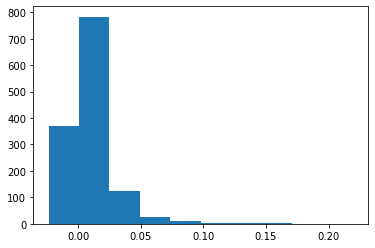

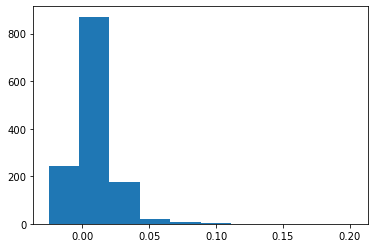

In [10]:
plt.hist(out["score_bin"])
plt.show()

plt.hist(out["score_cont"])
plt.show()

In [8]:
out = pd.DataFrame.from_dict(out)
out.sort_values("score_cont")

,gene,score_bin,score_cont,num_pairs
22,Cox5b,0.001989,-0.002388,7040
45,Ndufb9,0.017541,-0.002372,6214
15,Rplp2,0.024954,-0.002257,7574
21,Rps26,0.500000,-0.002177,7322
19,Rpl27a,0.025479,-0.002126,7300
...,...,...,...,...
61,Ndufs6,0.013765,0.004697,5594
58,Cox6a1,0.487917,0.014656,5462
33,Myl6,0.116899,0.018043,6604
4,Rps24,0.139660,0.019040,7998


In [13]:
out[out["score_cont"] > 0.01]

,gene,score_bin,score_cont,num_pairs
4,Rps24,0.139660,0.019040,7998
33,Myl6,0.116899,0.018043,6604
35,Atp5c1,-0.012813,0.024906,6634
58,Cox6a1,0.487917,0.014656,5462


In [48]:
(spinsums/2)/num_pairs

ZeroDivisionError: float division by zero

In [41]:
(spinsums/2)/num_pairs

0.1396599149787447

In [44]:
num_pairs

6604

In [40]:
spinsums

2234

In [26]:
 genedf[srow["col"]].quantile(0.5)

0.10926420493760075

In [16]:
genedf

,n.g_Start,barcode,gene,in_tissue,xcoord,pixval,pixquant,svd_z1,svd_z2,array_col,...,plot_xcoord,sort_junc,svd_z_sumsq,both_ann,ontology,exon_annR1B,cell,ycoord,exon_annR1A,svd_z0
39687,54.0,TTAGTTATTCGTGGCA-1,Rps24,1.0,6720.0,90.0,4.0,0.487861,-0.534576,91.0,...,7490.0,"(24490758, 24491750)",7.559026,True,null4.0,True,V1_Mouse_Kidney_TTAGTTATTCGTGGCA,7490.0,True,-2.652404
39688,192.0,ACGCGAAGTCAGACGA-1,Rps24,1.0,6952.0,86.0,2.0,-0.556408,1.042366,59.0,...,5287.0,"(24490758, 24491750)",2.990361,True,null2.0,True,V1_Mouse_Kidney_ACGCGAAGTCAGACGA,5287.0,True,-1.262634
39689,192.0,TCCGGTTCGTCCGGTC-1,Rps24,1.0,7190.0,87.0,2.0,0.204948,1.098529,53.0,...,4873.0,"(24490758, 24491750)",3.794900,True,null2.0,True,V1_Mouse_Kidney_TCCGGTTCGTCCGGTC,4873.0,True,-1.595660
39690,181.0,CAGAGACGGTCACCCA-1,Rps24,1.0,7191.0,88.0,3.0,-0.250177,0.893887,57.0,...,5149.0,"(24490758, 24491750)",2.923098,True,null3.0,True,V1_Mouse_Kidney_CAGAGACGGTCACCCA,5149.0,True,-1.435784
39691,231.0,TGGCAGCAGTAATAGT-1,Rps24,1.0,5755.0,89.0,4.0,-0.329092,0.275971,61.0,...,5429.0,"(24490758, 24493383)",4.500946,True,null4.0,True,V1_Mouse_Kidney_TGGCAGCAGTAATAGT,5429.0,True,-2.077615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41342,5.0,CTGTTCACTGCCTGTG-1,Rps24,1.0,3718.0,80.0,0.0,1.421210,0.309387,56.0,...,5092.0,"(24492116, 24493383)",3.758269,True,null0.0,True,V1_Mouse_Kidney_CTGTTCACTGCCTGTG,5092.0,True,-1.281683
41343,6.0,TGTGACTACGCCAGTC-1,Rps24,1.0,3603.0,88.0,3.0,-0.371929,-0.311261,73.0,...,6262.0,"(24492116, 24493383)",0.611621,True,null3.0,True,V1_Mouse_Kidney_TGTGACTACGCCAGTC,6262.0,True,-0.613519
41344,5.0,NaN,Rps24,NaN,NaN,NaN,NaN,1.665094,0.787626,NaN,...,NaN,"(24492116, 24493383)",4.299853,True,nullnan,True,V1_Mouse_Kidney_GTCTGCCGACTCGACG,NaN,True,-0.952345
41345,6.0,AAGGGACAGATTCTGT-1,Rps24,1.0,4206.0,87.0,2.0,-2.799862,-0.294781,92.0,...,7568.0,"(24492116, 24493383)",8.077122,True,null2.0,True,V1_Mouse_Kidney_AAGGGACAGATTCTGT,7568.0,True,0.388589


In [5]:
xcoord

4202.0

In [10]:
df

,n.g_Start,barcode,gene,in_tissue,xcoord,pixval,pixquant,svd_z1,svd_z2,array_col,...,plot_xcoord,sort_junc,svd_z_sumsq,both_ann,ontology,exon_annR1B,cell,ycoord,exon_annR1A,svd_z0
0,3.0,ATCTGGTTAAGACTGT-1,Lactb2,1.0,4202.0,102.0,9.0,2.060798e-03,1.358182e-17,76.0,...,6467.0,"(13626904, 13627356)",0.030103,True,null9.0,True,V1_Mouse_Kidney_ATCTGGTTAAGACTGT,6467.0,True,-0.173489
1,4.0,GCTAGGCACCACGGAG-1,Lactb2,1.0,7557.0,96.0,8.0,2.060798e-03,1.358182e-17,84.0,...,7005.0,"(13626904, 13627356)",0.030103,True,null8.0,True,V1_Mouse_Kidney_GCTAGGCACCACGGAG,7005.0,True,-0.173489
2,8.0,ATAGACGAAGAGAAAG-1,Lactb2,1.0,5033.0,87.0,2.0,2.060798e-03,1.358182e-17,45.0,...,4330.0,"(13626904, 13627356)",0.030103,True,null2.0,True,V1_Mouse_Kidney_ATAGACGAAGAGAAAG,4330.0,True,-0.173489
3,4.0,GTGATCCTTGTCATGA-1,Lactb2,1.0,8514.0,89.0,4.0,2.060798e-03,1.358182e-17,84.0,...,7002.0,"(13626904, 13627356)",0.030103,True,null4.0,True,V1_Mouse_Kidney_GTGATCCTTGTCATGA,7002.0,True,-0.173489
4,4.0,ACGCGGGCCAAGGACA-1,Lactb2,1.0,5157.0,96.0,8.0,2.060798e-03,1.358182e-17,62.0,...,5500.0,"(13626904, 13627356)",0.030103,True,null8.0,True,V1_Mouse_Kidney_ACGCGGGCCAAGGACA,5500.0,True,-0.173489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187314,NaN,TCGTCTTAGGCGTTAA-1,"Ctps2,S100g",1.0,7437.0,89.0,4.0,-3.949341e-03,-2.325284e-03,83.0,...,6937.0,"(162962240, 162964062)",0.000033,True,null4.0,True,V1_Mouse_Kidney_TCGTCTTAGGCGTTAA,6937.0,True,-0.003428
187315,NaN,TTACTCCGGCCGGGAA-1,Erdr1_1,1.0,5160.0,99.0,9.0,-1.560169e-18,5.217558e-17,78.0,...,6601.0,"(90793417, 90816349)",0.044444,True,null9.0,True,V1_Mouse_Kidney_TTACTCCGGCCGGGAA,6601.0,True,-0.210819
187316,NaN,ACGTAGATTGCTGATG-1,Erdr1_1,1.0,5038.0,91.0,5.0,-1.560169e-18,5.217558e-17,67.0,...,5844.0,"(90793417, 90816349)",0.044444,True,null5.0,True,V1_Mouse_Kidney_ACGTAGATTGCTGATG,5844.0,True,-0.210819
187317,NaN,GCAGATTAGGGATATC-1,Erdr1_1,1.0,5516.0,92.0,6.0,-1.358560e-16,-1.162782e-16,61.0,...,5430.0,"(90793417, 90816349)",0.400000,True,null6.0,True,V1_Mouse_Kidney_GCAGATTAGGGATATC,5430.0,True,0.632456
